The object of this notebook is to calculate the frequency and phase response of some passive filters.

In [212]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 5.0)

In [213]:
#Start of by defining the complex impedances of the three passives
suffixes = {"": 1, "G": 1e12, "M" : 1e6, "k" : 1e3, "m" : 1e-3, "u" : 1e-6, "n" : 1e-9, "p" : 1e-12}

import re
def parse_val(s):
    "parse strings like 1k 2M 5uF 2nH 2.5MHz 10V"
    mantissa, exponent, unit = re.match("([e|\d|\\.]+)(G|M|k|m|u|n|p|)(F|H|Ω|Hz|V|)$", s).groups()
    val = float(mantissa) * suffixes[exponent]
    if unit == '': unit = "Ω"
    return val, unit

assert(all((
        parse_val("5.2M") == (5.2e6, "Ω"),
        parse_val('6uF') == (6e-6, "F"),
        parse_val('750nH') == (750e-9, "H"),
        parse_val('1pHz') == (1e-12, "Hz"),
        parse_val('1GV') == (1e12, "V"),
    )))

from math import pi
def w(string):
    "convert string frequencies to angular frequency 2*pi*f"
    f, unit = parse_val(string)
    assert(unit == 'Hz')
    return 2*pi*f

assert(w('2.5MHz') == 2.5e6 * 2 * pi)
assert(w('2.5Hz') == 2.5 * 2 * pi)
    

def Z(string, ):
    "make passive components from strings like 1k 30mF and 500uH"
    val, unit = parse_val(string)
    if unit == 'Ω':
        def R(w):
            return val
        return R
    if unit == 'H':
        def L(w):
            return 1.0j * w * val
        return L
    if unit == 'F':
        def C(w):
            return 1.0 / (1.0j * w * val)
        return C
    if unit == 'V':
        def V(w):
            return val
        return V
    assert(false)

def C(val):
    def F(w):
        return 1.0 / (1.0j * w * val)
    return F
def L(val):
    def F(w):
        return (1.0j * w * val)
    return F
def R(val):
    def F(w):
        return val
    return F

def series(A, B):
    def Res(omega):
        return A(omega) + B(omega)
    return Res

def parra(A, B):
    def Res(omega):
        return A(omega) * B(omega) / (A(omega) + B(omega))
    return Res

        
assert(all([
    #resistors    
    Z('1k')(w("1Hz")) == Z('1000')(w("1kHz")) == Z('1kΩ')(w("1MHz")),
    abs(Z('100uH')(w("20Hz"))) < abs(Z('100uH')(w("1kHz"))),
    abs(Z('100uF')(w("20Hz"))) > abs(Z('100uF')(w("1kHz"))),
    all([Z("1M")(10**n) == R(1e6)(10**n) for n in range(2, 10)]),
    all([Z("1uH")(10**n) == L(1e-6)(10**n) for n in range(2, 10)]),
    all([Z("1nF")(10**n) == C(1e-9)(10**n) for n in range(2, 10)]),
    ]))


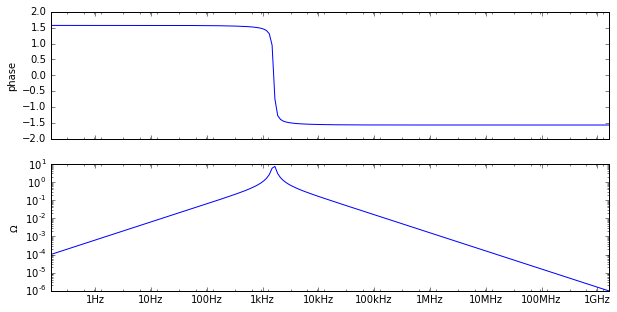

In [230]:

def logplot_Z(Z):
    f, (ax2, ax1) = plt.subplots(2,1, sharex ="col")
    ws = np.logspace(0, 10, 200)
    ax1.loglog(ws, abs(Z(ws)))
    ax1.set_ylabel("Ω")
    
    ax2.set_xscale('log')
    ax2.set_ylabel("phase")
    plt.xticks(
        10**np.arange(0, 10) * 2 * pi,
            ["1Hz", "10Hz", "100Hz", "1kHz", "10kHz", "100kHz", "1MHz", "10MHz", '100MHz', '1GHz'])
    ax2.plot(ws, np.angle(Z(ws)))
    
def logplot_output(O):
    V, Z = O
    f, (ax2, ax1) = plt.subplots(2,1, sharex ="col")
    ws = np.logspace(0, 10, 200)
    ax1.loglog(ws, abs(V(ws)))
    ax1.set_ylabel("V")
    
    ax2.set_xscale('log')
    ax2.set_ylabel("|Z|")
    plt.xticks(
        10**np.arange(0, 10) * 2 * pi,
    ["1Hz", "10Hz", "100Hz", "1kHz", "10kHz", "100kHz", "1MHz", "10MHz", '100MHz', '1GHz'])
    ax2.set_yrange([1e2, 1e-2])
    ax2.plot(ws, abs(Z(ws)))
    

notch_filter = parra(Z("10Ω"), parra(Z("100uF"), Z("100uH")))
logplot_Z(notch_filter)
    

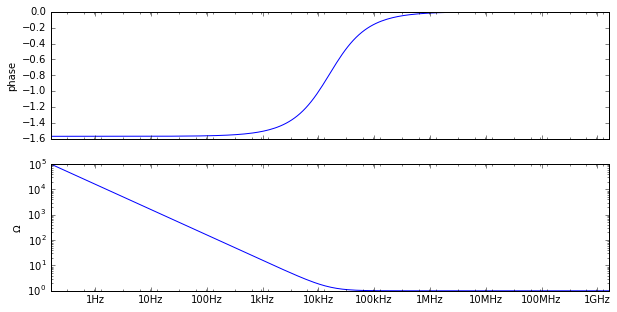

In [215]:
high_pass = series(Z("1Ω"), Z('10uF'))
logplot_Z(high_pass)

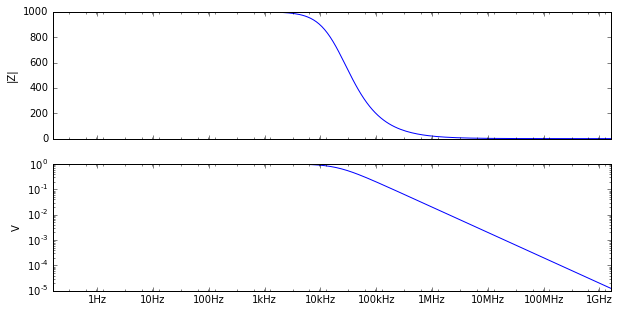

In [216]:
#define a thevenin source as a (V(w), Z(w)) tuple

#define filters in terms of what effect they have on a thevenin source
def passive_filter(Z1, Z2):
    def apply_to(thevenin):
        Vin, Zin = thevenin
        def Vout(w): return Vin(w) * Z2(w) / (Z1(w) + Z2(w) + Zin(w))
        def Zout(w): return Z2(w) * (Z1(w) + Zin(w)) / (Z1(w) + Z2(w) + Zin(w)) 
        return Vout, Zout
        
    return apply_to

stiff_source = (Z("1V"), Z("0Ω"))

Res = Z("1kΩ")
f = w("20kHz")
Cap = C(1.0 / (Res(0) * f))
low_pass = passive_filter(Res, Cap)
output = low_pass(stiff_source)

logplot_output(output)


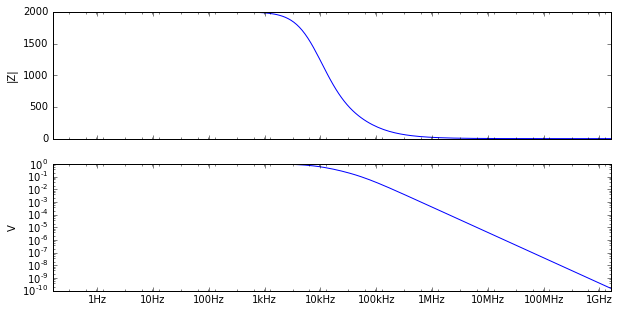

In [217]:
#what happens if we chain the same two low pass filters together?
output = low_pass(low_pass(stiff_source))
logplot_output(output)

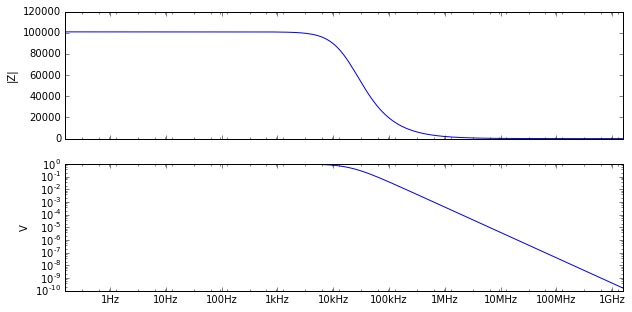

In [218]:
#That didn't work because the output impedance of the first filter was too high
#and the input impedance of the second too low compared to it.
#If we define a high impedance low pass first it should work better
Res = Z("100kΩ")
f = w("20kHz")
Cap = C(1.0 / (Res(0) * f))
highZ_low_pass = passive_filter(Res, Cap)

output = highZ_low_pass(low_pass(stiff_source))
logplot_output(output)

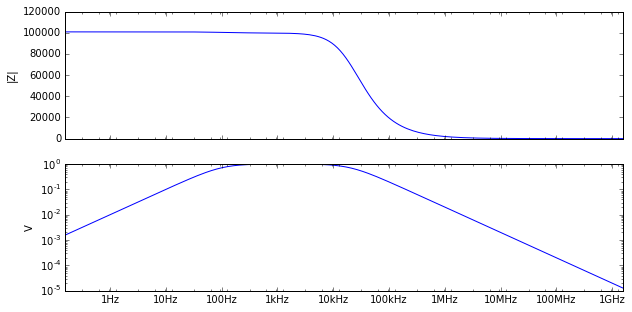

In [219]:
#That still didn't really work, what about a high pass and low pass together?
Res = Z("1kΩ")
f = w("100Hz")
Cap = C(1.0 / (Res(0) * f))
high_pass = passive_filter(Cap, Res)

output = highZ_low_pass(high_pass(stiff_source))
logplot_output(output)

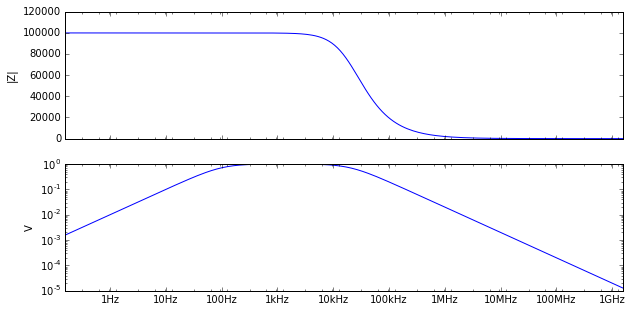

In [220]:
def buffer(factor):
    def apply_to(thevenin):
        Vin, Zin = thevenin
        def Vout(w): return Vin(w)
        def Zout(w): return Zin(w) * factor
        return Vout, Zout
        
    return apply_to


buf = buffer(1e-3)
output = highZ_low_pass(buf(high_pass(stiff_source)))
logplot_output(output)

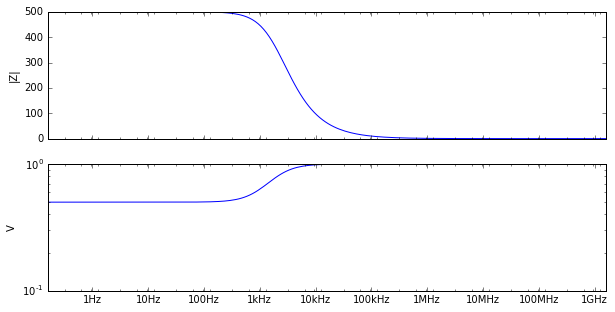

In [221]:
#high emphasis filter
Res = Z("1kΩ")
f = w("1kHz")
Cap = C(1.0 / (Res(0) * f))

emph = passive_filter(parra(Res, Cap), Res)
logplot_output(emph(stiff_source))

0.1

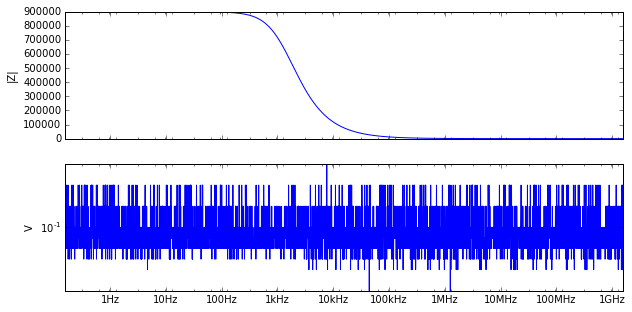

In [229]:
#ex 1.44 from Art of electronics
ground_path = parra(Z("120pF"), Z("1MΩ"))
signal_path = parra(C(120e-12 /9), R(1e6 * 9)) #should be 9 but that makes it underflow
overall = passive_filter(signal_path, ground_path)
out = overall(stiff_source)
logplot_output(out)
V, _ = out
abs(V(w("1Hz")))